# Binomial Trees and Trinomial Trees

## Load the Libs we need

In [1]:
# import Lib
import pandas as pd
import datetime as dt
import pytz
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as si
import math
import networkx as nx
# import module
from datetime import datetime, timezone
from datetime import date, time
from math import trunc
from dateutil.parser import parse

## Binomial Tree Model

#### European Options

In [2]:
def mb_binomial_tree_european(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, option_type='call'):
    """
    Calculate the price of a European option using the binomial tree method.

    Parameters:
    num_steps (int): Number of steps in the binomial tree.
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    option_type (str): Type of option ('call' or 'put'). Defaults to 'call'.

    Returns:
    float: The price of the European option.
    """
    dt = time_to_expiration / num_steps
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Price tree
    price_tree = np.zeros([num_steps + 1, num_steps + 1])

    for i in range(num_steps + 1):
        for j in range(i + 1):
            price_tree[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Option value
    option = np.zeros([num_steps + 1, num_steps + 1])

    # Calculate the option price at expiration
    if option_type == 'call':
        option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), (price_tree[:, num_steps] - strike_price))
    elif option_type == 'put':
        option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), (strike_price - price_tree[:, num_steps]))
    else:
        raise ValueError("Invalid option type. Please use 'call' or 'put'")

    # Calculate option price at t=0
    for i in range(num_steps - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = math.exp(-risk_free_rate * dt) * (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1])
    
    return option[0, 0]

In [3]:
# Create a DataFrame to hold the results
results = pd.DataFrame(columns=['Steps (n)', 'Option Type', 'Price'])

# Function to add results to the DataFrame
def add_results(num_steps, option_type):
    price = mb_binomial_tree_european(num_steps, 100, 105, 1, 0.05, 0.2, option_type)
    results.loc[len(results)] = [num_steps, option_type, price]

# Testing the function for different cases
for n in [2, 6, 100]:
    add_results(n, 'call')
    add_results(n, 'put')

# Display the results
results

,Steps (n),Option Type,Price
0,2,call,8.081247
1,2,put,7.960337
2,6,call,8.208375
3,6,put,8.087464
4,100,call,8.026229
5,100,put,7.905319


#### Visualizing the underlying prices

In [4]:
def mb_binomial_tree_underlying_prices(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(70, 140), y_ticks=10):
    """
    Generate and display a binomial tree for underlying stock prices.

    Parameters:
    num_steps (int): Number of steps in the binomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (70, 140).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the binomial tree graph.
    """
    # Delta time
    dt = time_to_expiration / num_steps
    # Up and down factors
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Initialize stock price tree
    stock = np.zeros([num_steps + 1, num_steps + 1])
    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Plotting the binomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for stock prices
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the binomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(i + 1):
            plt.text(i, stock[j, i], f'{stock[j, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with thinner and dotted lines
    for i in range(num_steps):
        for j in range(i + 1):
            plt.plot([i, i + 1], [stock[j, i], stock[j, i + 1]], 'k--', lw=0.8)
            plt.plot([i, i + 1], [stock[j, i], stock[j + 1, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Binomial Tree of Underlying Stock Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)
    
    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)    

    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_binomial_tree_underlying_prices_n{num_steps}.png', dpi=300)

    plt.show()

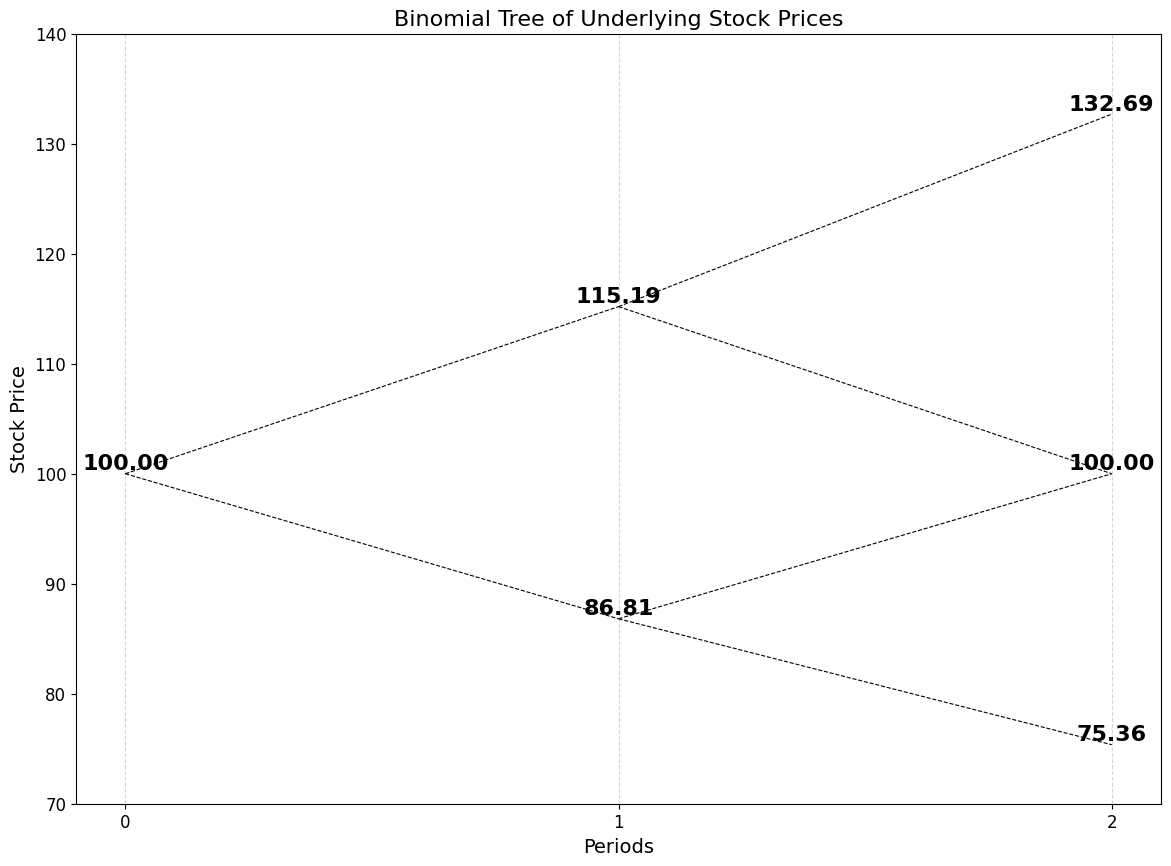

In [5]:
# n = 2
mb_binomial_tree_underlying_prices(2, 100, 105, 1, 0.05, 0.2, y_limit=(70, 140), y_ticks=8)

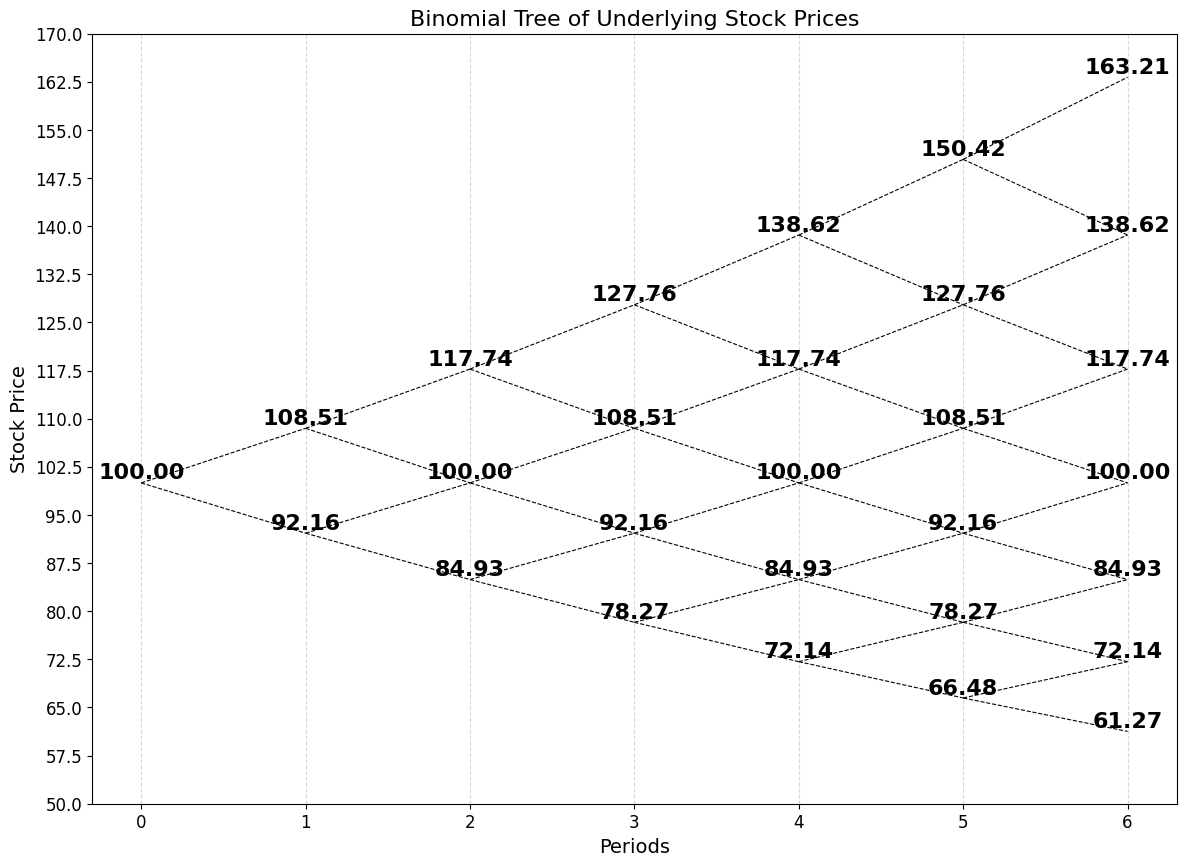

In [6]:
# n = 6
mb_binomial_tree_underlying_prices(6, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=17)

#### Visualizing the call prices

In [7]:
def mb_binomial_tree_european_call(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(70, 140), y_ticks=10):
    """
    Calculate the price of a European call option using a binomial tree and display the tree.

    Parameters:
    num_steps (int): Number of steps in the binomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (70, 140).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the binomial tree graph with option prices.
    """
    # Delta time
    dt = time_to_expiration / num_steps
    # Up and down factors
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Initialize stock price tree
    stock = np.zeros([num_steps + 1, num_steps + 1])
    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option = np.zeros([num_steps + 1, num_steps + 1])
    option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), stock[:, num_steps] - strike_price)

    # Calculate the option price at t=0
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = math.exp(-risk_free_rate * dt) * (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1])

    # Plotting the binomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for stock prices
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the binomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(i + 1):
            plt.text(i, stock[j, i], f'{option[j, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with thinner and dotted lines
    for i in range(num_steps):
        for j in range(i + 1):
            plt.plot([i, i + 1], [stock[j, i], stock[j, i + 1]], 'k--', lw=0.8)
            plt.plot([i, i + 1], [stock[j, i], stock[j + 1, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Binomial Tree of European Call Option Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)
    
    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_binomial_tree_european_call_n{num_steps}.png', dpi=300)

    plt.show()

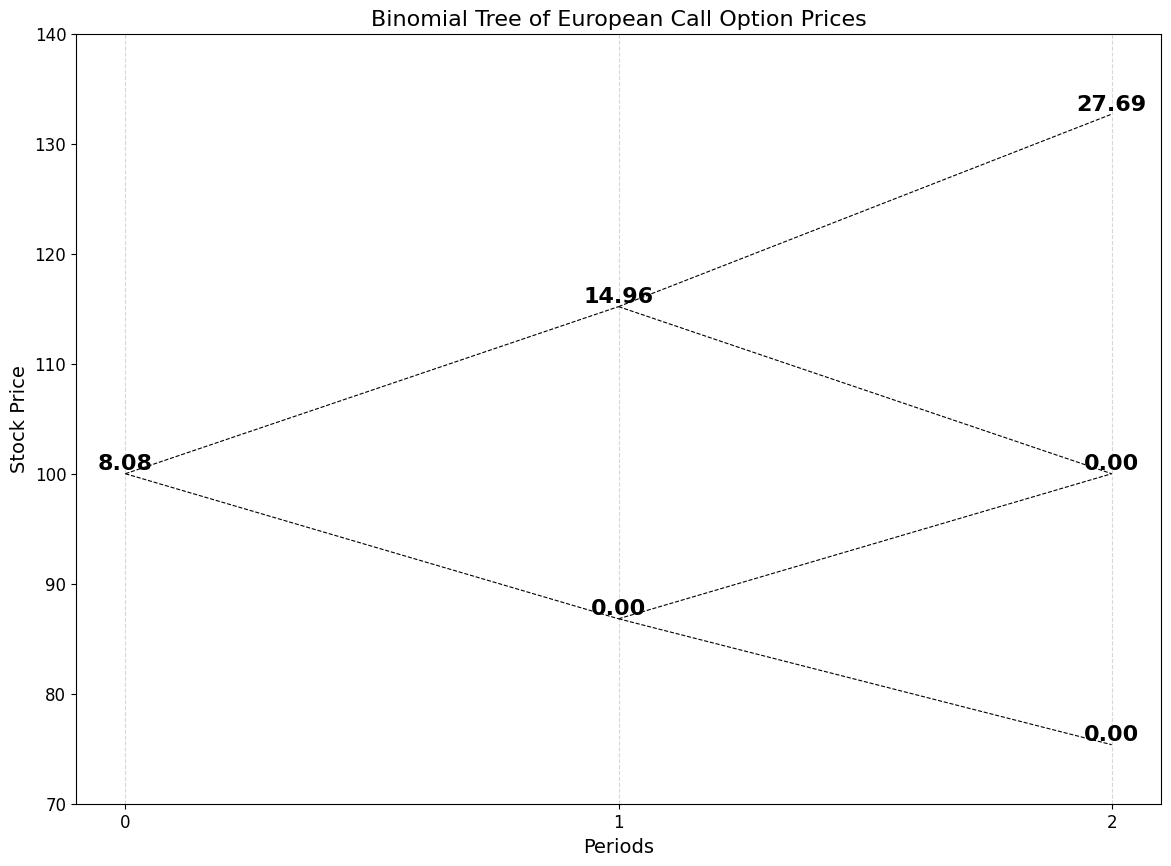

In [8]:
# n = 2
mb_binomial_tree_european_call(2, 100, 105, 1, 0.05, 0.2, y_limit=(70, 140), y_ticks=8)

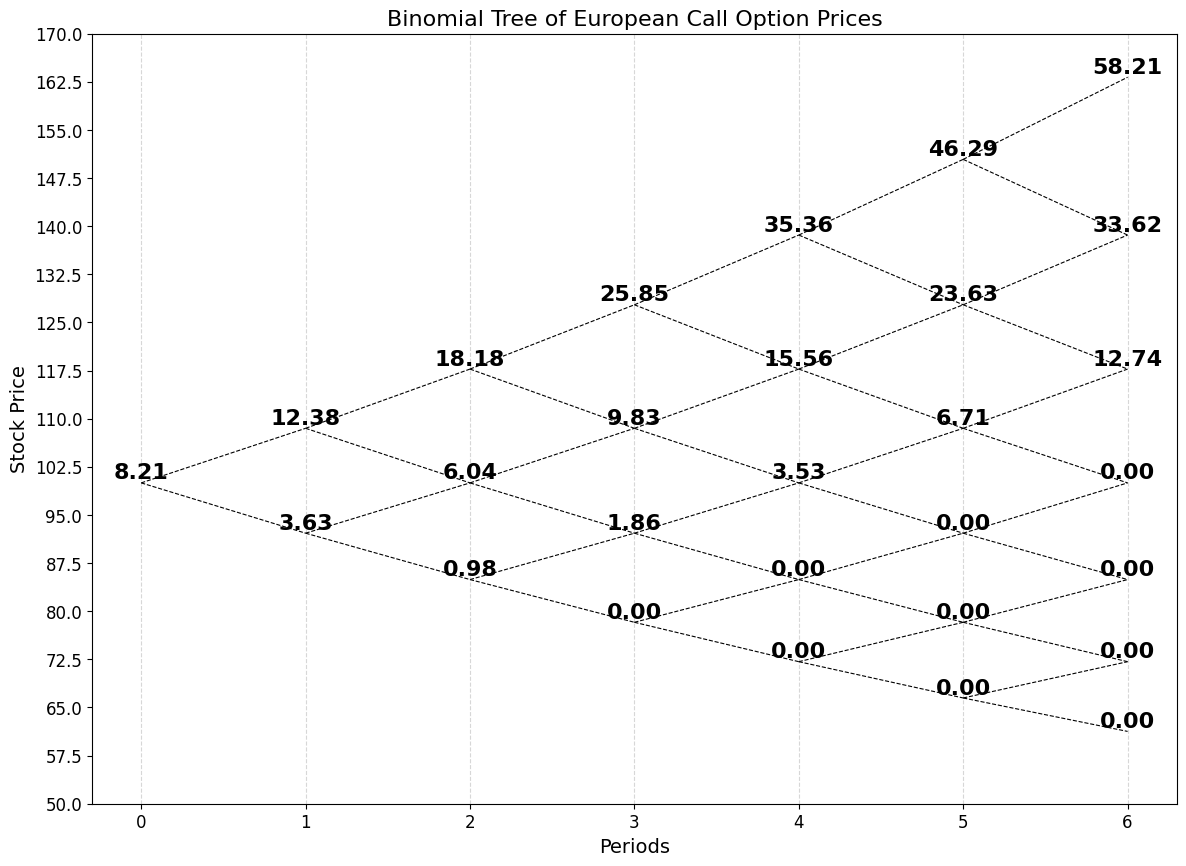

In [9]:
# n = 6
mb_binomial_tree_european_call(6, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=17)

#### Visualizing the put prices

In [10]:
def mb_binomial_tree_european_put(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(70, 140), y_ticks=10):
    """
    Calculate the price of a European put option using a binomial tree and display the tree.

    Parameters:
    num_steps (int): Number of steps in the binomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (70, 140).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the binomial tree graph with option prices.
    """
    # Delta time
    dt = time_to_expiration / num_steps
    # Up and down factors
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Initialize stock price tree
    stock = np.zeros([num_steps + 1, num_steps + 1])
    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option = np.zeros([num_steps + 1, num_steps + 1])
    option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), strike_price - stock[:, num_steps])  # Change here for put option

    # Calculate the option price at t=0
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = math.exp(-risk_free_rate * dt) * (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1])

    # Plotting the binomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for stock prices
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the binomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(i + 1):
            plt.text(i, stock[j, i], f'{option[j, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with thinner and dotted lines
    for i in range(num_steps):
        for j in range(i + 1):
            plt.plot([i, i + 1], [stock[j, i], stock[j, i + 1]], 'k--', lw=0.8)
            plt.plot([i, i + 1], [stock[j, i], stock[j + 1, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Binomial Tree of European Put Option Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)
    
    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_binomial_tree_european_put_n{num_steps}.png', dpi=300)

    plt.show()

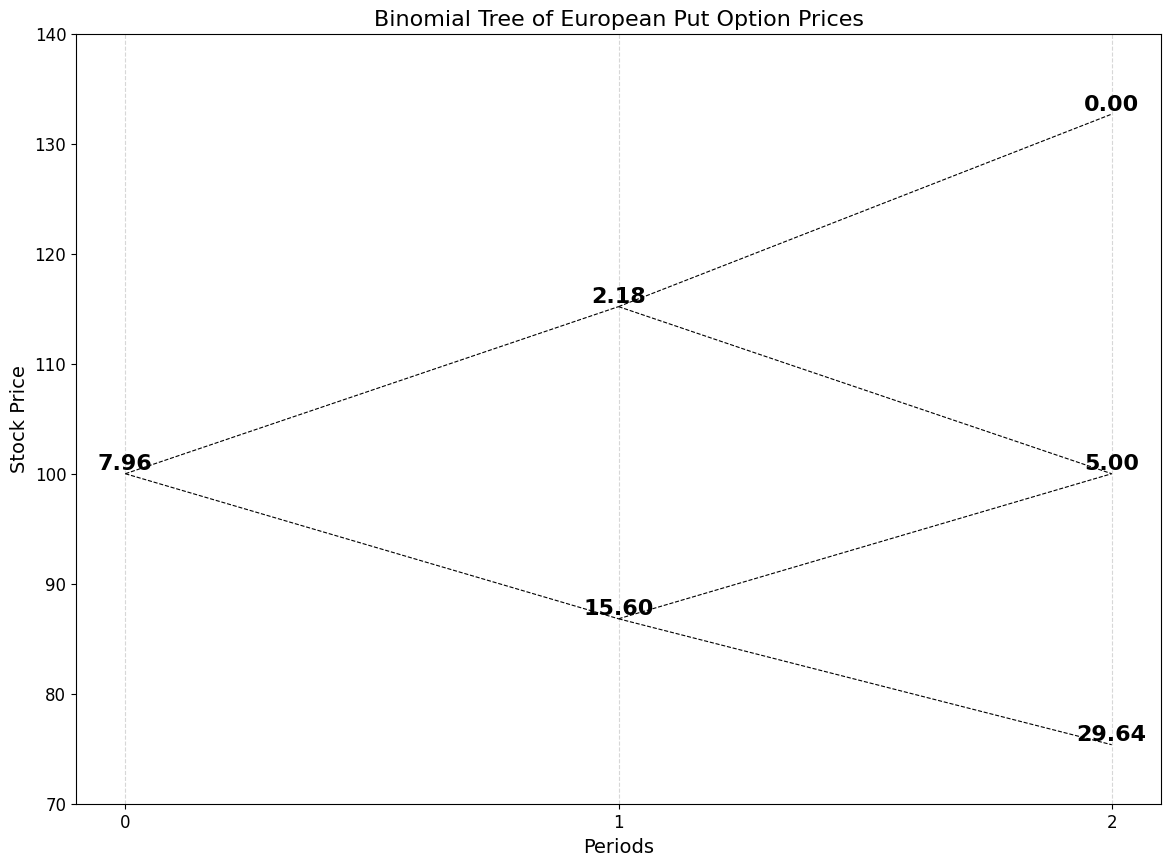

In [11]:
# n = 2
mb_binomial_tree_european_put(2, 100, 105, 1, 0.05, 0.2, y_limit=(70, 140), y_ticks=8)

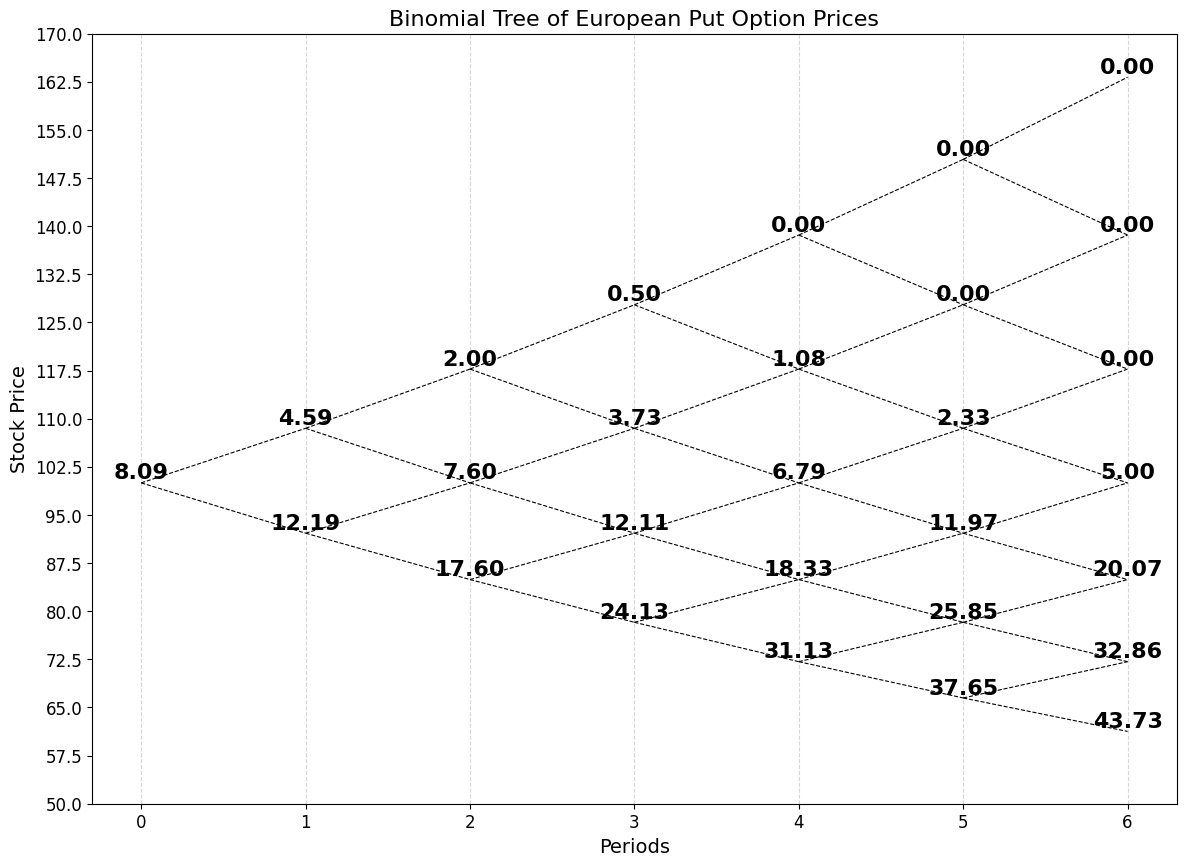

In [12]:
# n = 6
mb_binomial_tree_european_put(6, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=17)

#### American Options

In [13]:
def mb_binomial_tree_american(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, option_type='call'):
    """
    Calculate the price of an American option using a binomial tree.

    Parameters:
    num_steps (int): Number of steps in the binomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    option_type (str): Type of option ('call' or 'put'). Defaults to 'call'.

    Returns:
    float: The price of the American option.
    """
    # Delta time
    dt = time_to_expiration / num_steps
    # Up and down factors
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)
    
    # Price tree
    price_tree = np.zeros([num_steps + 1, num_steps + 1])
    
    for i in range(num_steps + 1):
        for j in range(i + 1):
            price_tree[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Option value
    option = np.zeros([num_steps + 1, num_steps + 1])

    # Calculate the option price at expiration
    if option_type == 'call':
        option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), (price_tree[:, num_steps] - strike_price))
    elif option_type == 'put':
        option[:, num_steps] = np.maximum(np.zeros(num_steps + 1), (strike_price - price_tree[:, num_steps]))
    else:
        raise ValueError("Invalid option type. Please use 'call' or 'put'")

    # Calculate option price at t=0
    for i in range(num_steps - 1, -1, -1):
        for j in range(0, i + 1):
            if option_type == 'call':
                exercise = np.maximum(price_tree[j, i] - strike_price, 0)
            elif option_type == 'put':
                exercise = np.maximum(strike_price - price_tree[j, i], 0)
            
            no_exercise = math.exp(-risk_free_rate * dt) * (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1])
            option[j, i] = np.maximum(exercise, no_exercise)
    
    return option[0, 0]

# Testing the function with an American call
print("American call price:  {:.4f}".format(mb_binomial_tree_american(10, 100, 105, 1, 0.05, 0.2, 'call')))
# Testing the function with an American put
print("American put price:   {:.4f}".format(mb_binomial_tree_american(10, 100, 105, 1, 0.05, 0.2, 'put')))


American call price:  8.1763
American put price:   8.8550


### Barrier Options

In [14]:
def mb_binomial_tree_barrier_call(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, barrier_level, y_limit=(60, 190), y_ticks=14):
    """
    Calculate the price of a down-and-out barrier call option using a binomial tree and display the tree.

    Parameters:
    num_steps (int): Number of steps in the binomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    barrier_level (float): The barrier level for the option.
    y_limit (tuple): Limits for the y-axis (min, max). Default is (0, 140).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the binomial tree graph with option prices.
    """
    # Delta time
    dt = time_to_expiration / num_steps
    # Up and down factors
    u = math.exp(volatility * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Initialize stock price tree
    stock = np.zeros([num_steps + 1, num_steps + 1])
    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock[j, i] = initial_stock_price * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option = np.zeros([num_steps + 1, num_steps + 1])

    # Calculate the option price at expiration
    for j in range(num_steps + 1):
        if stock[j, num_steps] > barrier_level:
            option[j, num_steps] = max(0, stock[j, num_steps] - strike_price)

    # Calculate the option price at t=0
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = math.exp(-risk_free_rate * dt) * (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1])
            if stock[j, i] <= barrier_level:  # If the stock price hits the barrier, the option is worthless
                option[j, i] = 0

    # Plotting the binomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16
    title_font_size = 16
    label_font_size = 14
    tick_font_size = 12

    # Plot the binomial tree nodes
    for i in range(num_steps + 1):
        for j in range(i + 1):
            plt.text(i, stock[j, i], f'{option[j, i]:.2f}', ha='center', va='bottom',
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree
    for i in range(num_steps):
        for j in range(i + 1):
            plt.plot([i, i + 1], [stock[j, i], stock[j, i + 1]], 'k--', lw=0.8)
            plt.plot([i, i + 1], [stock[j, i], stock[j + 1, i + 1]], 'k--', lw=0.8)

    # Set axis and labels
    plt.title('Binomial Tree of Down-and-Out Barrier Call Option Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)

    # Set y-axis limits
    plt.ylim(y_limit)
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.savefig(f'mb_binomial_tree_barrier_call_n{num_steps}.png', dpi=300)
    plt.show()


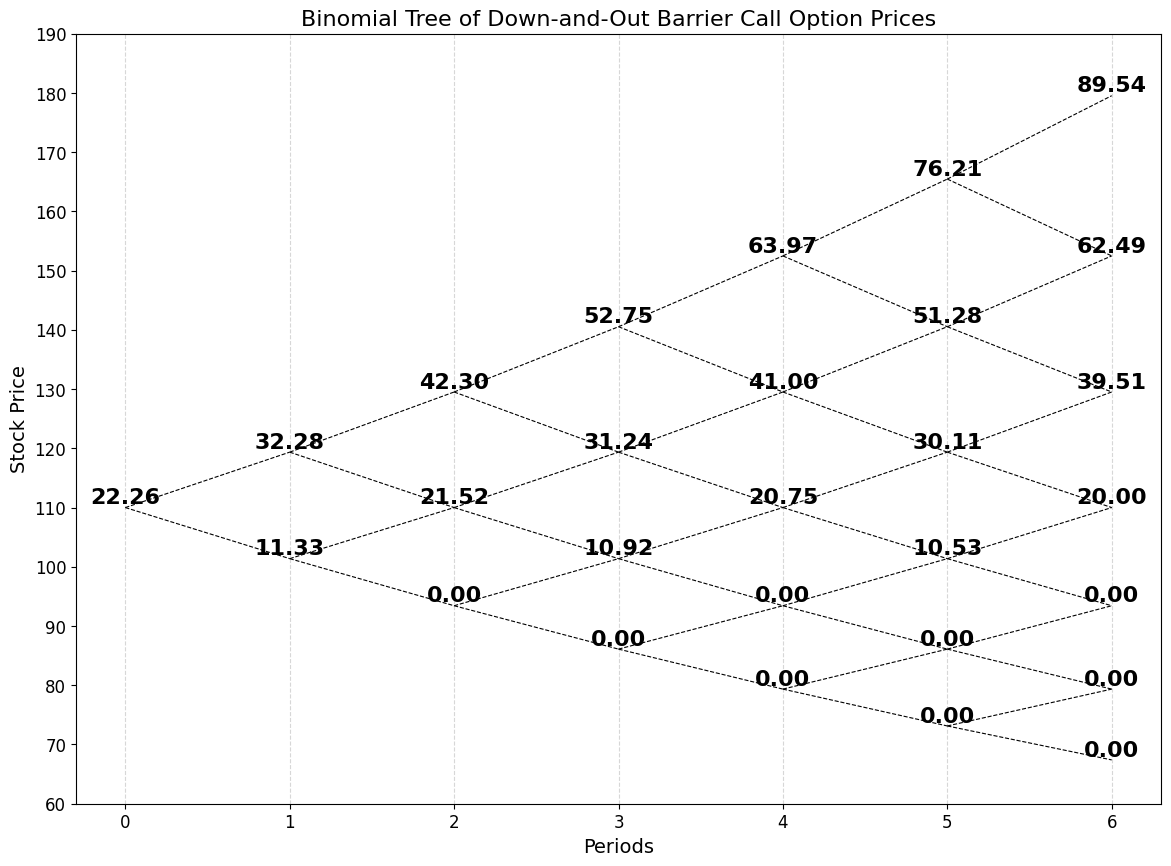

NameError: name 'barrier_call_price' is not defined

In [15]:
# Define parameters for the barrier option
num_steps = 6
initial_stock_price = 110  # Example initial stock price
strike_price = 90           # Example strike price
time_to_expiration = 1      # 1 year to expiration
risk_free_rate = 0.05       # 5% risk-free interest rate
volatility = 0.2            # 20% volatility
barrier_level = 100         # Barrier level for the option

# Call the function to display the binomial tree and option prices
mb_binomial_tree_barrier_call(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, barrier_level)

print(f"The price of the down-and-out barrier call option is: {barrier_call_price:.2f}")

## Trinomial Tree Model

In [ ]:
def mb_trinomial_tree_european(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, option_type='call'):
    """
    Calculate the price of a European option using a trinomial tree.

    Parameters:
    num_steps (int): Number of steps in the trinomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    option_type (str): Type of option ('call' or 'put'). Defaults to 'call'.

    Returns:
    float: The price of the European option.
    """
    # Calculating delta T
    dt = time_to_expiration / num_steps

    # Parameters for trinomial tree
    dx = volatility * math.sqrt(3 * dt)
    nu = risk_free_rate - 0.5 * volatility**2
    pu = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 + nu * dt / dx)
    pd = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 - nu * dt / dx)
    pm = 1 - pu - pd

    # Initialize arrays for storing stock prices and option values
    stock_price = np.zeros((2*num_steps + 1, num_steps + 1))
    option_value = np.zeros((2*num_steps + 1, num_steps + 1))

    # Calculate stock prices
    for i in range(-num_steps, num_steps + 1):
        stock_price[i, :] = initial_stock_price * np.exp(i * dx)

    # Calculate option values at maturity
    if option_type == 'call':
        option_value[:, num_steps] = np.maximum(stock_price[:, num_steps] - strike_price, 0)
    elif option_type == 'put':
        option_value[:, num_steps] = np.maximum(strike_price - stock_price[:, num_steps], 0)

    # Perform backward iteration to find option value at t=0
    for j in range(num_steps - 1, -1, -1):
        for i in range(-j, j + 1):
            option_value[i, j] = math.exp(-risk_free_rate * dt) * (
                pu * option_value[i + 1, j + 1] + 
                pm * option_value[i, j + 1] + 
                pd * option_value[i - 1, j + 1]
            )
    
    return option_value[0, 0]

# Testing the function with a European call
print("European call price:  {:.4f}".format(mb_trinomial_tree_european(2, 100, 105, 1, 0.05, 0.2, 'call')))
# Testing the function with a European put
print("European put price:   {:.4f}".format(mb_trinomial_tree_european(2, 100, 105, 1, 0.05, 0.2, 'put')))


In [ ]:
def mb_trinomial_tree_underlying_prices(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(70, 140), y_ticks=10):
    """
    Generate and display a trinomial tree for underlying stock prices.

    Parameters:
    num_steps (int): Number of steps in the trinomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (70, 140).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the trinomial tree graph with underlying stock prices.
    """
    # Calculating delta T
    dt = time_to_expiration / num_steps

    # Parameters for trinomial tree
    dx = volatility * math.sqrt(3 * dt)
    nu = risk_free_rate - 0.5 * volatility**2

    # Initialize arrays for storing stock prices
    stock_price = np.zeros((2 * num_steps + 1, num_steps + 1))

    # Calculate stock prices
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            stock_price[j + num_steps, i] = initial_stock_price * np.exp(j * dx)

    # Plotting the trinomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for stock prices
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the trinomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            plt.text(i, stock_price[j + num_steps, i], f'{stock_price[j + num_steps, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with dotted lines
    for i in range(num_steps):
        for j in range(-i, i + 1):
            # Downward left edge
            if j - 1 >= -i - 1:  # Adjusting condition to ensure lines at edges are drawn
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j - 1 + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward middle edge
            plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward right edge
            if j + 1 <= i + 1:  # Adjusting condition to ensure lines at edges are drawn
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + 1 + num_steps, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Trinomial Tree of Underlying Stock Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)

    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_trinomial_tree_underlying_prices_n{num_steps}.png', dpi=300)
    
    plt.show()

In [ ]:
# n = 2
mb_trinomial_tree_underlying_prices(2, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=9)

In [ ]:
# n = 6
mb_trinomial_tree_underlying_prices(6, 100, 105, 1, 0.05, 0.2, y_limit=(30, 240), y_ticks=15)

#### Visualizing the call prices

In [ ]:
def mb_trinomial_tree_european_call(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(0, 240), y_ticks=10):
    """
    Calculate the price of a European call option using a trinomial tree and display the tree.

    Parameters:
    num_steps (int): Number of steps in the trinomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (0, 240).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the trinomial tree graph with option values.
    """
    # Calculating delta T
    dt = time_to_expiration / num_steps

    # Parameters for trinomial tree
    dx = volatility * math.sqrt(3 * dt)
    nu = risk_free_rate - 0.5 * volatility**2
    pu = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 + nu * dt / dx)
    pd = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 - nu * dt / dx)
    pm = 1 - pu - pd

    # Initialize arrays for storing stock prices and option values
    stock_price = np.zeros((2*num_steps + 1, num_steps + 1))
    option_value = np.zeros((2*num_steps + 1, num_steps + 1))

    # Calculate stock prices
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            stock_price[j + num_steps, i] = initial_stock_price * np.exp(j * dx)

    # Calculate option values at maturity
    option_value[:, num_steps] = np.maximum(stock_price[:, num_steps] - strike_price, 0)

    # Perform backward iteration to find option value at t=0
    for j in range(num_steps - 1, -1, -1):
        for i in range(-j, j + 1):
            option_value[i + num_steps, j] = math.exp(-risk_free_rate * dt) * (
                pu * option_value[i + num_steps + 1, j + 1] + 
                pm * option_value[i + num_steps, j + 1] + 
                pd * option_value[i + num_steps - 1, j + 1]
            )

    # Plotting the trinomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for option values
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the trinomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            plt.text(i, stock_price[j + num_steps, i], f'{option_value[j + num_steps, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with dotted lines
    for i in range(num_steps):
        for j in range(-i, i + 1):
            # Downward left edge
            if j - 1 >= -i - 1:  # Adjusting condition to ensure lines at edges are drawn
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j - 1 + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward middle edge
            plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward right edge
            if j + 1 <= i + 1:  # Adjusting condition to ensure lines at edges are drawn
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + 1 + num_steps, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Trinomial Tree of European Call Option Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)

    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_trinomial_tree_european_call_n{num_steps}.png', dpi=300)
    
    plt.show()

In [ ]:
# n = 2
mb_trinomial_tree_european_call(2, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=9)

In [ ]:
# n = 6
mb_trinomial_tree_european_call(6, 100, 105, 1, 0.05, 0.2, y_limit=(30, 240), y_ticks=15)

#### Visualizing the put prices

In [ ]:
def mb_trinomial_tree_european_put(num_steps, initial_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, y_limit=(0, 240), y_ticks=10):
    """
    Calculate the price of a European put option using a trinomial tree and display the tree.

    Parameters:
    num_steps (int): Number of steps in the trinomial tree (n).
    initial_stock_price (float): The initial stock price (S).
    strike_price (float): The strike price of the option (K).
    time_to_expiration (float): Time to expiration in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the stock (σ).
    y_limit (tuple): Limits for the y-axis (min, max). Default is (0, 240).
    y_ticks (int): Number of ticks on the y-axis. Default is 10.

    Returns:
    None: Displays the trinomial tree graph with option values.
    """
    # Calculating delta T
    dt = time_to_expiration / num_steps

    # Parameters for trinomial tree
    dx = volatility * math.sqrt(3 * dt)
    nu = risk_free_rate - 0.5 * volatility**2
    pu = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 + nu * dt / dx)
    pd = 0.5 * ((volatility**2 * dt + nu**2 * dt**2) / dx**2 - nu * dt / dx)
    pm = 1 - pu - pd

    # Initialize arrays for storing stock prices and option values
    stock_price = np.zeros((2*num_steps + 1, num_steps + 1))
    option_value = np.zeros((2*num_steps + 1, num_steps + 1))

    # Calculate stock prices
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            stock_price[j + num_steps, i] = initial_stock_price * np.exp(j * dx)

    # Calculate option values at maturity
    option_value[:, num_steps] = np.maximum(strike_price - stock_price[:, num_steps], 0)

    # Perform backward iteration to find option value at t=0
    for j in range(num_steps - 1, -1, -1):
        for i in range(-j, j + 1):
            option_value[i + num_steps, j] = math.exp(-risk_free_rate * dt) * (
                pu * option_value[i + num_steps + 1, j + 1] + 
                pm * option_value[i + num_steps, j + 1] + 
                pd * option_value[i + num_steps - 1, j + 1]
            )

    # Plotting the trinomial tree
    plt.figure(figsize=(14, 10))

    # Font properties for the prices and titles
    price_font_size = 16  # Font size for option values
    title_font_size = 16  # Font size for title
    label_font_size = 14  # Font size for axis labels
    tick_font_size = 12    # Font size for tick labels

    # Plot the trinomial tree nodes with customizable font size and weight
    for i in range(num_steps + 1):
        for j in range(-i, i + 1):
            plt.text(i, stock_price[j + num_steps, i], f'{option_value[j + num_steps, i]:.2f}', ha='center', va='bottom', 
                     fontsize=price_font_size, fontweight='bold', color='black')

    # Draw connecting lines for the tree with dotted lines
    for i in range(num_steps):
        for j in range(-i, i + 1):
            # Downward left edge
            if j - 1 >= -i - 1:
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j - 1 + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward middle edge
            plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + num_steps, i + 1]], 'k--', lw=0.8)
            # Downward right edge
            if j + 1 <= i + 1:
                plt.plot([i, i + 1], [stock_price[j + num_steps, i], stock_price[j + 1 + num_steps, i + 1]], 'k--', lw=0.8)

    # Set axis and labels with customized font sizes
    plt.title('Trinomial Tree of European Put Option Prices', fontsize=title_font_size)
    plt.xlabel('Periods', fontsize=label_font_size)
    plt.ylabel('Stock Price', fontsize=label_font_size)
    plt.xticks(range(num_steps + 1), fontsize=tick_font_size)

    # Set y-axis limits for better centering
    plt.ylim(y_limit)  # Adjust the y-axis limits to center the tree
    plt.yticks(np.linspace(y_limit[0], y_limit[1], y_ticks), fontsize=tick_font_size)  # Adding a y-axis scale for stock prices
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Save the figure in high resolution for print purposes with function name and number of periods
    plt.savefig(f'mb_trinomial_tree_european_put_n{num_steps}.png', dpi=300)
    
    plt.show()

In [ ]:
# n = 2
mb_trinomial_tree_european_put(2, 100, 105, 1, 0.05, 0.2, y_limit=(50, 170), y_ticks=9)

In [ ]:
# n = 6
mb_trinomial_tree_european_put(6, 100, 105, 1, 0.05, 0.2, y_limit=(30, 240), y_ticks=15)

## Black and Scholes model mb_black_scholes function for comparison

In [ ]:
def mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option_type='call'):
    """
    Calculate the Black-Scholes option price.

    Parameters:
    spot_price (float): Current spot price of the underlying asset (S).
    strike_price (float): Strike price of the option (K).
    time_to_maturity (float): Time to maturity in years (T).
    risk_free_rate (float): Risk-free interest rate (r).
    volatility (float): Volatility of the underlying asset (σ).
    option_type (str): Type of option ('call' or 'put'). Defaults to 'call'.

    Returns:
    float: The calculated price of the option.
    """
    # Calculate d1 and d2
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    # Calculate the option price based on the type
    if option_type == 'call':
        result = (spot_price * si.norm.cdf(d1, 0.0, 1.0) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        result = (strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(-d2, 0.0, 1.0) - spot_price * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Invalid option type. Please use 'call' or 'put'.")

    return result

# Example usage
call_price = mb_black_scholes(100, 105, 1, 0.05, 0.2, option_type='call')
put_price = mb_black_scholes(100, 105, 1, 0.05, 0.2, option_type='put')

print(f"The Black-Scholes price of the call option is: {call_price:.4f}")
print(f"The Black-Scholes price of the put option is:  {put_price:.4f}")
